In [1]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
from pyAgrum.lib.discretizer import Discretizer
import re
import pickle
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [2]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints, rotation='vertical')
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(f"{var_str} States")
        axes[i].set_ylabel("Probability")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))


def get_info(D, auditDict, var):
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints


def optimal_bins_elbow_method(time_series, min_bins=2, max_bins=15, plot=True):
    """
    Determines the optimal number of bins using the elbow method with KMeans clustering.

    Parameters:
    - time_series: numpy array or list of numerical values (1D time series)
    - min_bins: minimum number of bins to consider
    - max_bins: maximum number of bins to consider
    - plot: whether to plot the elbow curve

    Returns:
    - optimal_bins: The optimal number of bins for discretization
    """
    time_series = np.array(time_series).reshape(-1, 1)  # Ensure data is 2D for KMeans

    inertia_values = []
    bin_range = range(min_bins, max_bins + 1)

    for k in bin_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(time_series)
        inertia_values.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(bin_range, inertia_values, curve="convex", direction="decreasing")
    optimal_bins = kneedle.elbow

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(bin_range, inertia_values, marker="o", linestyle="-", label="Inertia")
        plt.axvline(optimal_bins, linestyle="--", color="red", label=f"Optimal Bins: {optimal_bins}")
        plt.xlabel("Number of Bins (Clusters)")
        plt.ylabel("Inertia (WCSS)")
        plt.title("Elbow Method for Optimal Bin Selection")
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_bins

In [3]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['test-17022025']

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod is TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
    
# concat_df = concat_df[concat_df['R_V']>0.01]
# concat_df = concat_df[concat_df['R_V']<=0.75]

    
D = concat_df.drop('pf_elapsed_time', axis=1)
D = D.drop('T', axis=1)
D = D.drop('R_X', axis=1)
D = D.drop('R_Y', axis=1)
D = D.drop('G_X', axis=1)
D = D.drop('G_Y', axis=1)
D = D.drop('NP', axis=1)
D = D.drop('R_B', axis=1)
D = D.drop('ELT', axis=1)
D = D.drop('C_S', axis=1)
D = D.drop('TOD', axis=1)
D = D.drop('WP', axis=1)
D = D.drop('PD', axis=1)
original_names = list(D.columns)
D.columns = [f'{v}t' for v in original_names]

# Add lagged variable
for v in original_names:
    D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
D = D.iloc[1:].reset_index(drop=True)  # Remove first row
D = D.iloc[:-1].reset_index(drop=True)  # Remove last row

# D = D[D['R_Vt']>0.01]

Loading : test-17022025_H1_door-entrance.csv
Loading : test-17022025_H2_door-entrance.csv
Loading : test-17022025_H3_door-entrance.csv
Loading : test-17022025_H4_door-entrance.csv
Loading : test-17022025_H5_door-entrance.csv
Loading : test-17022025_H6_door-entrance.csv
Loading : test-17022025_H7_door-entrance.csv
Loading : test-17022025_H8_door-entrance.csv
Loading : test-17022025_H9_door-entrance.csv
Loading : test-17022025_H10_door-entrance.csv


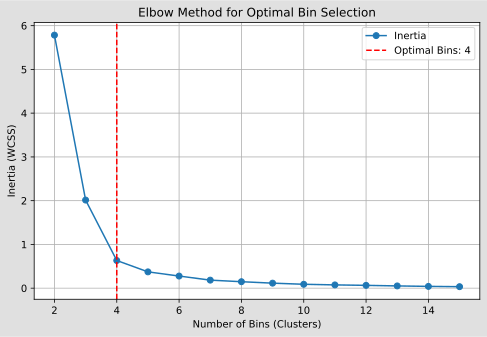

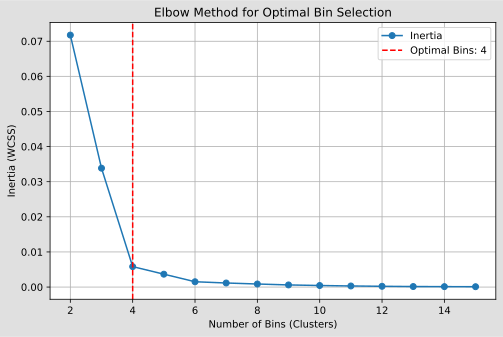

/tmp/ipykernel_985182/4112664273.py:15: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  template = discretizer.discretizedBN(D)



** audit **
- R_Vt : 
    + method : quantile
    + param : 4
    + type : Continuous
    + minInData : 0.0001638882523025
    + maxInData : 0.7522156380090905
- Lt : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- ECt : 
    + method : quantile
    + param : 4
    + type : Continuous
    + minInData : 0.0222280991984335
    + maxInData : 0.1807175991842705
- R_V0 : 
    + method : quantile
    + param : 4
    + type : Continuous
    + minInData : 0.0001638882523025
    + maxInData : 0.7522156380090905
- L0 : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- EC0 : 
    + method : quantile
    + param : 4
    + type : Continuous
    + minInData : 0.0222280991984335
    + maxInData : 0.1807175991842705


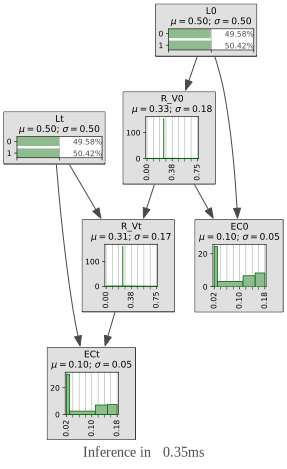

In [4]:
# DISCRETIZATION -- BN CREATION

discretizer=Discretizer(defaultDiscretizationMethod='quantile')
RV_bins = optimal_bins_elbow_method(D['R_Vt'].values)
EC_bins = optimal_bins_elbow_method(D['ECt'].values)
# discretizer.setDiscretizationParameters('R_V0','quantile', 5)
# discretizer.setDiscretizationParameters('R_Vt','quantile', 5)
# discretizer.setDiscretizationParameters('EC0','quantile', 5)
# discretizer.setDiscretizationParameters('ECt','quantile', 5)
discretizer.setDiscretizationParameters('R_V0','quantile', RV_bins)
discretizer.setDiscretizationParameters('R_Vt','quantile', RV_bins)
discretizer.setDiscretizationParameters('EC0','quantile', EC_bins)
discretizer.setDiscretizationParameters('ECt','quantile', EC_bins)

template = discretizer.discretizedBN(D)
auditDict=discretizer.audit(D)
print()
print("** audit **")
for var in auditDict:
    print(f"- {var} : ")
    for k,v in auditDict[var].items():
        print(f"    + {k} : {v}")
        
# template.addArc("WP0", "PD0")
# template.addArc("WPt", "PDt")
# template.addArc("TOD0", "PD0")
# template.addArc("TODt", "PDt")
# template.addArc("PD0", "PDt")
template.addArc("L0", "EC0")
template.addArc("L0", "R_V0")
template.addArc("R_V0", "EC0")
template.addArc("Lt", "R_Vt")
template.addArc("Lt", "ECt")
template.addArc("R_Vt", "ECt")
template.addArc("R_V0", "R_Vt")
# template.addArc("C_S0", "EC0")
# template.addArc("C_St", "ECt")
# template.addArc("C_S0", "R_V0")
# template.addArc("C_St", "R_Vt")
learner = pyAgrum.BNLearner(D, template)
learner.useSmoothingPrior()
bn = learner.learnParameters(template)

time_slices_bn = gdyn.getTimeSlices(bn, size=20)

gnb.showInference(bn)

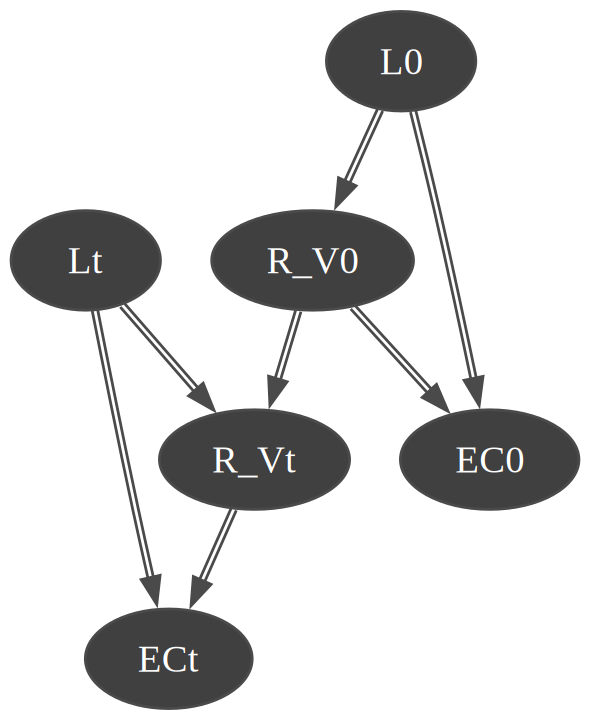

<IPython.core.display.Math object>

In [5]:
cm = pyc.CausalModel(bn)

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
cslnb.showCausalModel(cm, size="10!")
a = pyc.doCalculusWithObservation(cm,"EC0", {"R_V0"})
display(Math(a.toLatex()))



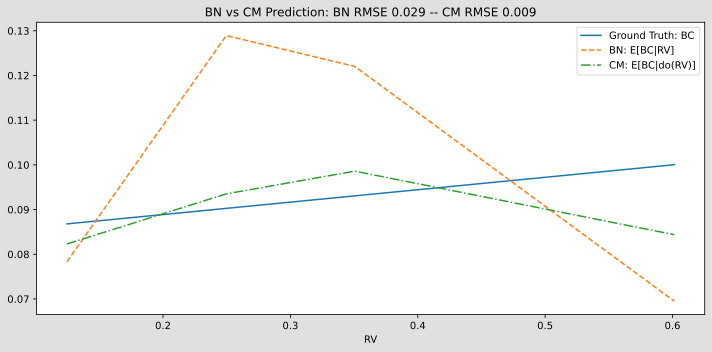

In [6]:

static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
NOLOAD_ROBOT_MAX_VEL = 0.75
LOAD_ROBOT_MAX_VEL = 0.25
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(NOLOAD_ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V0')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC0')
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

for RV_val in midpoints_R_V0:
    GTLOAD = time * (K_l_s + K_l_d * RV_val) 
    GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    target_var = 'EC0'
    target_var_str = format_evidence_for_latex({target_var: None})
        
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    bn_prior = ie.posterior(target_var)
    evidence = {"R_V0": RV_bin_idx}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
    bayes_pred = (time/STEP)*pred_bn
        
    # --- CausalModel prediction ---
    formula, adj, exp = pyc.causalImpact(cm, on="EC0", doing="R_V0", values=evidence)
    posterior_causal = adj.toarray()
    pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
    causal_pred = (time/STEP)*pred_causal
        
    gt_noload.append(GTNOLOAD)
    gt_load.append(GTLOAD)
    gts.append((GTNOLOAD+GTLOAD)/2)
    bayes_preds.append(bayes_pred)
    causal_preds.append(causal_pred)

plt.figure(figsize=(10, 5))
# plt.plot(midpoints_R_V0, gt_noload, label=f'Ground Truth: {target_var_str}', linestyle='-')
# plt.plot(midpoints_R_V0, gt_load, label=f'Ground Truth: {target_var_str}', linestyle='-')
plt.plot(midpoints_R_V0, gts, label=f'Ground Truth: BC', linestyle='-')
plt.plot(midpoints_R_V0, bayes_preds, label=f'BN: E[BC|RV]', linestyle='--')
plt.plot(midpoints_R_V0, causal_preds, label=f'CM: E[BC|do(RV)]', linestyle='-.')
# plt.plot(midpoints_R_V0, gts, label=f'Ground Truth: {target_var_str}', linestyle='-')
# plt.plot(midpoints_R_V0, bayes_preds, label=f'BN: E[{target_var_str}|{evidence_str}]', linestyle='--')
# plt.plot(midpoints_R_V0, causal_preds, label=f'CM: E[{target_var_str}|do({evidence_str})]', linestyle='-.')
bn_RMSE = np.sqrt(np.mean((np.array(bayes_preds) - np.array(gts)) ** 2))
cm_RMSE = np.sqrt(np.mean((np.array(causal_preds) - np.array(gts)) ** 2))
plt.title(f'BN vs CM Prediction: BN RMSE {bn_RMSE:.3f} -- CM RMSE {cm_RMSE:.3f}')
plt.xlabel(r'RV')
# plt.xlabel(r'$R_{V_{t-1}}$')
plt.legend()
plt.tight_layout()
plt.show()



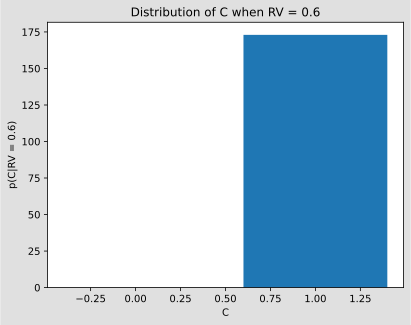

GT 0.09999999999999999
BN 0.06949225562148516
CM 0.0843721123703336


In [12]:
static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
NOLOAD_ROBOT_MAX_VEL = 0.75
LOAD_ROBOT_MAX_VEL = 0.25
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(NOLOAD_ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V0')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC0')
STEP = 5
time = 5
gt_noload = []
gt_load = []
gts = []
bayes_preds = []
causal_preds = []

RV_val = 0.6
GTLOAD = time * (K_l_s + K_l_d * RV_val) 
GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

RV_bin_idx = find_bin(RV_val, edges_R_V0)
target_var = 'EC0'
target_var_str = format_evidence_for_latex({target_var: None})


# R_V_selection = D
# counts, bins = np.histogram(R_V_selection['L0'].values, bins=2)
# plt.hist([0, 1], bins, weights=counts, alpha=0.7, label='L0')
# plt.xticks([0.25, 0.75], ['0', '1'])
# plt.xlabel('C')
# plt.ylabel(f'p(C)')
# plt.title(f"Distribution of C")
# plt.show()


# --- BN prediction ---
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V0": RV_bin_idx}
R_V_selection = D[D['R_V0'] > 0.3]
counts, bins = np.histogram(R_V_selection['L0'].values, bins=2)
# counts = [39 ,0]
plt.bar(range(len(counts)), counts)
# plt.xticks([0, 1], ['0', '1'])
plt.xlabel('C')
plt.ylabel(f'p(C|RV = {RV_val})')
plt.title(f"Distribution of C when RV = {RV_val}")
plt.show()
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
bayes_pred = (time/STEP)*pred_bn
        
# --- CausalModel prediction ---
formula, adj, exp = pyc.causalImpact(cm, on="EC0", doing="R_V0", values=evidence)
posterior_causal = adj.toarray()
pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
causal_pred = (time/STEP)*pred_causal
        
print(f"GT {(GTNOLOAD+GTLOAD)/2}")
print(f"BN {bayes_pred}")
print(f"CM {causal_pred}")

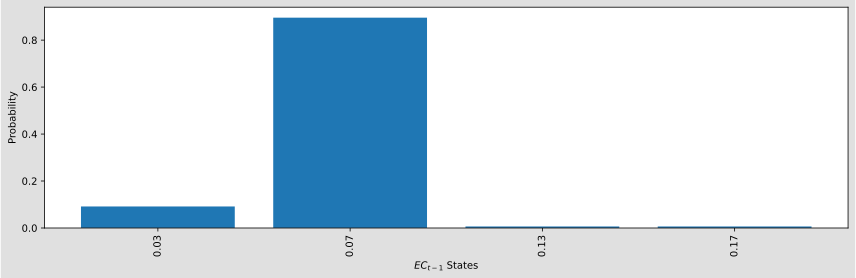

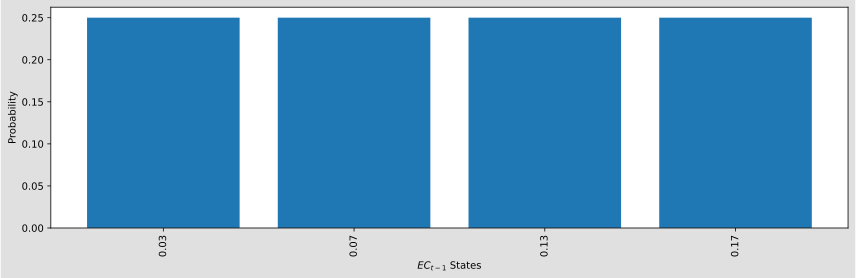

In [13]:
static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
NOLOAD_ROBOT_MAX_VEL = 0.75
LOAD_ROBOT_MAX_VEL = 0.25
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(NOLOAD_ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V0')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC0')
STEP = 5
time = 5

RV_val = 0.6
GTLOAD = time * (K_l_s + K_l_d * RV_val) 
GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

RV_bin_idx = find_bin(RV_val, edges_R_V0)
target_var = 'EC0'
target_var_str = format_evidence_for_latex({target_var: None})


# --- BN prediction ---
ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V0": RV_bin_idx, "L0": 0}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
bayes_pred = (time/STEP)*pred_bn
plot_distributions("EC0", [(bn_posterior_values, "")], midpoints_EC0)

ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior(target_var)
evidence = {"R_V0": RV_bin_idx, "L0": 1}
evidence_str = format_evidence_for_latex(evidence)
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
bn_posterior_values = bn_posterior.toarray()
pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
bayes_pred = (time/STEP)*pred_bn
plot_distributions("EC0", [(bn_posterior_values, "")], midpoints_EC0)

    